In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

pd.plotting.register_matplotlib_converters()
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data
from prepare import prep_store_data_prophet, split_store_data
from summarize import df_summary

# mySQL `tsa_item_demand` database
df = get_store_data()

# view full DF
pd.set_option('display.max_columns', None)

Wrangle

- DateFrame
- columns = 'ds' & 'y'
- 'ds' is datetime, 'y' is numeric

In [2]:
df.head()

,sale_id,sale_date,store_id,item_id,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state
0,1,2013-01-01,1,1,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,2,2013-01-02,1,1,11,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2,3,2013-01-03,1,1,14,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
3,4,2013-01-04,1,1,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
4,5,2013-01-05,1,1,10,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


In [3]:
def prep_data(df):
    return df.assign(ds=pd.to_datetime(df.sale_date)).sort_values('ds').assign(y=df.sale_amount * df.item_price).groupby(['ds'])['y'].sum().reset_index().set_index('ds')

In [4]:
df = prep_data(df)

In [5]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [6]:
validate.shape

(366, 1)

Set cap and floor

In [8]:
train['cap'] = 500000
train['floor'] = 0

In [9]:
train.head()

,y,cap,floor
ds,,,
2013-01-01,73844.01,500000,0
2013-01-02,73570.58,500000,0
2013-01-03,78169.48,500000,0
2013-01-04,84467.73,500000,0
2013-01-05,87621.85,500000,0


In [10]:
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

In [11]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniforml

In [12]:
# from here go to cross validation to model on
m = Prophet(daily_seasonality = False, growth = 'logistic', weekly_seasonality = 'auto', changepoint_range = 0.9)
m.add_country_holidays(country_name='US')
m.fit(train)
m.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10    Independence Day (Observed)
dtype: object

In [13]:
future = m.make_future_dataframe(periods = len(validate))
future['cap'] = 500000
future['floor'] = 0

In [14]:
future.head()

,ds,cap,floor
0,2013-01-01,500000,0
1,2013-01-02,500000,0
2,2013-01-03,500000,0
3,2013-01-04,500000,0
4,2013-01-05,500000,0


In [15]:
future.tail()

,ds,cap,floor
1456,2016-12-27,500000,0
1457,2016-12-28,500000,0
1458,2016-12-29,500000,0
1459,2016-12-30,500000,0
1460,2016-12-31,500000,0


In [16]:
future.shape

(1461, 3)

In [17]:
forecast = m.predict(future)

In [18]:
forecast.head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,113241.863853,500000,0,61327.649336,75778.417345,113241.863853,113241.863853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1869.961434,1869.961434,1869.961434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-44727.230959,-44727.230959,-44727.230959,1869.961434,1869.961434,1869.961434,-9915.135041,-9915.135041,-9915.135041,-36682.057352,-36682.057352,-36682.057352,0.0,0.0,0.0,68514.632895
1,2013-01-02,113265.333546,500000,0,60270.180324,73600.146846,113265.333546,113265.333546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-46525.828912,-46525.828912,-46525.828912,0.000000,0.000000,0.000000,-9798.423395,-9798.423395,-9798.423395,-36727.405517,-36727.405517,-36727.405517,0.0,0.0,0.0,66739.504635
2,2013-01-03,113288.806679,500000,0,67833.355807,81588.405770,113288.806679,113288.806679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-38461.757225,-38461.757225,-38461.757225,0.000000,0.000000,0.000000,-1656.322100,-1656.322100,-1656.322100,-36805.435125,-36805.435125,-36805.435125,0.0,0.0,0.0,74827.049454
3,2013-01-04,113312.283251,500000,0,76745.707089,90693.574908,113312.283251,113312.283251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29639.080832,-29639.080832,-29639.080832,0.000000,0.000000,0.000000,7271.604018,7271.604018,7271.604018,-36910.684850,-36910.684850,-36910.684850,0.0,0.0,0.0,83673.202419
4,2013-01-05,113335.763262,500000,0,85694.997862,99720.543136,113335.763262,113335.763262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20850.477052,-20850.477052,-20850.477052,0.000000,0.000000,0.000000,16186.326418,16186.326418,16186.326418,-37036.803471,-37036.803471,-37036.803471,0.0,0.0,0.0,92485.286210


In [19]:
forecast.shape

(1461, 57)

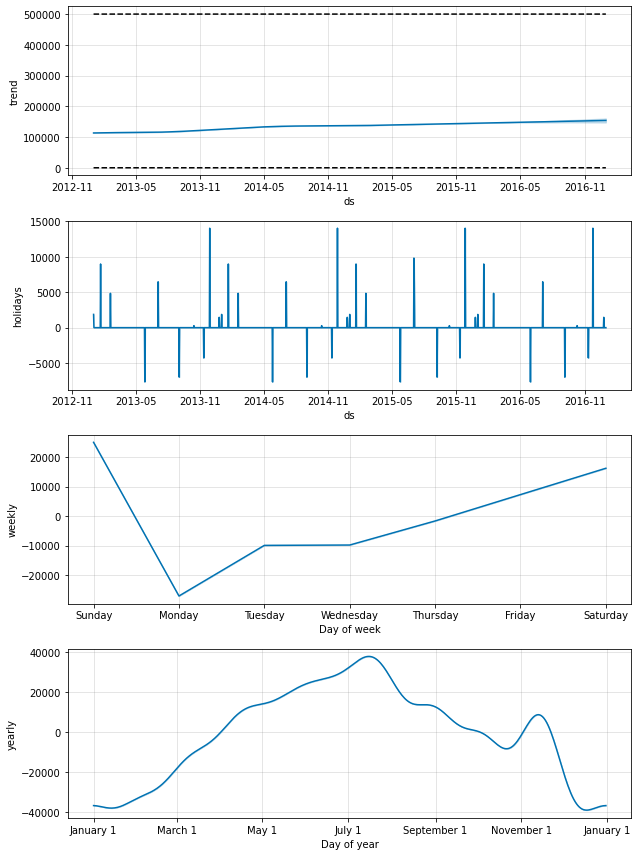

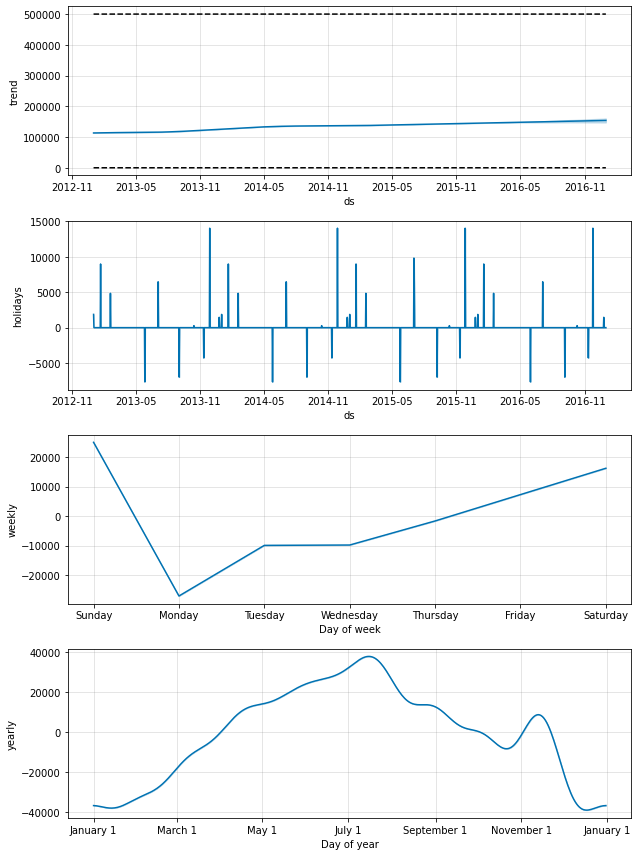

In [20]:
m.plot_components(forecast, 'holidays')

In [21]:
forecast = pd.concat([forecast, df[:'2016'].reset_index().y], axis=1)

In [24]:
forecast[(forecast['Christmas Day'] + 
          forecast['Thanksgiving'] + 
          forecast["New Year's Day"]).abs() > 0]\
        [['ds', 'y', 'yhat', 'Christmas Day', 'Thanksgiving', "New Year's Day"]][-10:]

,ds,y,yhat,Christmas Day,Thanksgiving,New Year's Day
358,2013-12-25,82576.48,79279.446556,1457.861978,0.000000,0.000000
365,2014-01-01,83630.73,80986.444651,0.000000,0.000000,1869.961434
695,2014-11-27,140309.12,138778.755119,0.000000,14039.021378,0.000000
723,2014-12-25,99840.03,99201.643028,1457.861978,0.000000,0.000000
730,2015-01-01,92586.37,100561.800574,0.000000,0.000000,1869.961434
1059,2015-11-26,148941.86,149238.719922,0.000000,14039.021378,0.000000
1088,2015-12-25,112176.34,116110.455835,1457.861978,0.000000,0.000000
1095,2016-01-01,107875.26,117643.955119,0.000000,0.000000,1869.961434
1423,2016-11-24,159026.05,160713.390906,0.000000,14039.021378,0.000000
1454,2016-12-25,135125.06,142749.913240,1457.861978,0.000000,0.000000


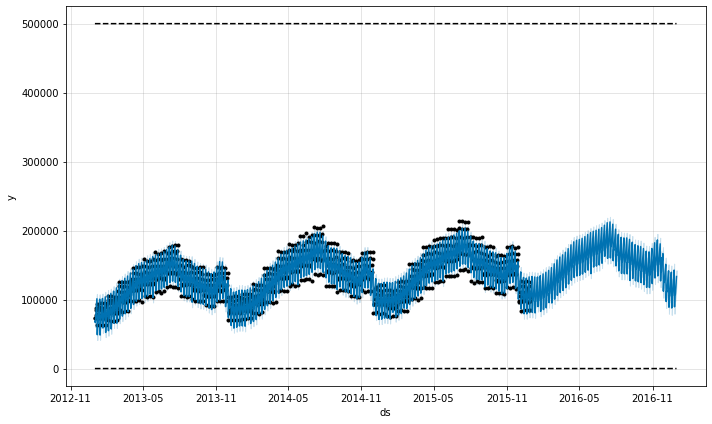

In [27]:
# Plot predictions

fig1 = m.plot(forecast)

In [28]:
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(forecast.y, forecast.yhat))

6335.201737416671

In [35]:
forecast['cutoff'] = train.ds.iloc[-1]

In [37]:
forecast.head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,cutoff
0,2013-01-01,113241.863853,500000,0,61327.649336,75778.417345,113241.863853,113241.863853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1869.961434,1869.961434,1869.961434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-44727.230959,-44727.230959,-44727.230959,1869.961434,1869.961434,1869.961434,-9915.135041,-9915.135041,-9915.135041,-36682.057352,-36682.057352,-36682.057352,0.0,0.0,0.0,68514.632895,73844.01,2015-12-31
1,2013-01-02,113265.333546,500000,0,60270.180324,73600.146846,113265.333546,113265.333546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-46525.828912,-46525.828912,-46525.828912,0.000000,0.000000,0.000000,-9798.423395,-9798.423395,-9798.423395,-36727.405517,-36727.405517,-36727.405517,0.0,0.0,0.0,66739.504635,73570.58,2015-12-31
2,2013-01-03,113288.806679,500000,0,67833.355807,81588.405770,113288.806679,113288.806679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-38461.757225,-38461.757225,-38461.757225,0.000000,0.000000,0.000000,-1656.322100,-1656.322100,-1656.322100,-36805.435125,-36805.435125,-36805.435125,0.0,0.0,0.0,74827.049454,78169.48,2015-12-31
3,2013-01-04,113312.283251,500000,0,76745.707089,90693.574908,113312.283251,113312.283251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29639.080832,-29639.080832,-29639.080832,0.000000,0.000000,0.000000,7271.604018,7271.604018,7271.604018,-36910.684850,-36910.684850,-36910.684850,0.0,0.0,0.0,83673.202419,84467.73,2015-12-31
4,2013-01-05,113335.763262,500000,0,85694.997862,99720.543136,113335.763262,113335.763262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20850.477052,-20850.477052,-20850.477052,0.000000,0.000000,0.000000,16186.326418,16186.326418,16186.326418,-37036.803471,-37036.803471,-37036.803471,0.0,0.0,0.0,92485.286210,87621.85,2015-12-31


In [36]:
y = pd.DataFrame(df[:'2016'])

In [32]:
#df_cv = cross_validation(m, initial = '730 days', period = '90 days', horizon = '180 days')

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-06,93574.842199,86929.413859,99915.579196,88606.83,2015-01-05
1,2015-01-07,93531.621553,87220.045556,99965.044731,87704.19,2015-01-05
2,2015-01-08,101367.671231,94406.886509,108231.618358,94971.00,2015-01-05
3,2015-01-09,109950.118216,103463.843638,115948.889926,101312.99,2015-01-05
4,2015-01-10,119027.164776,112576.182140,125504.836946,106900.92,2015-01-05


In [31]:
df_cv.shape

(540, 6)

In [34]:
df_cv.cutoff.value_counts()

2015-07-04    180
2015-04-05    180
2015-01-05    180
Name: cutoff, dtype: int64

In [38]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,5.525043e+07,7433.063504,6334.841206,0.050739,0.046787,0.518519
1,19 days,5.495105e+07,7412.897334,6225.533663,0.050680,0.042635,0.518519
2,20 days,5.837134e+07,7640.113596,6337.189964,0.051243,0.040600,0.537037
3,21 days,6.016438e+07,7756.570422,6532.597171,0.052242,0.041929,0.518519
4,22 days,6.209769e+07,7880.208678,6679.525202,0.053133,0.041929,0.518519


In [41]:
df_p.shape

(163, 7)

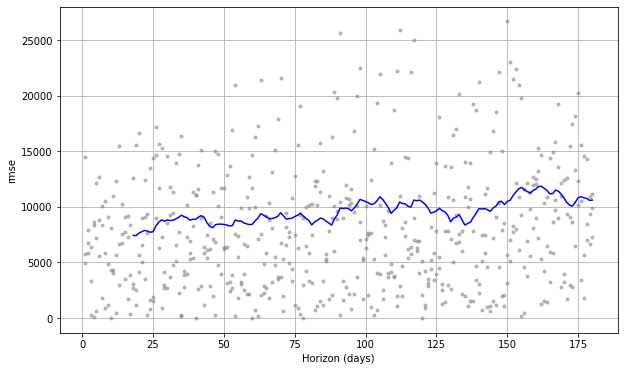

In [46]:
fig  = plot_cross_validation_metric(df_cv, metric = 'rmse')

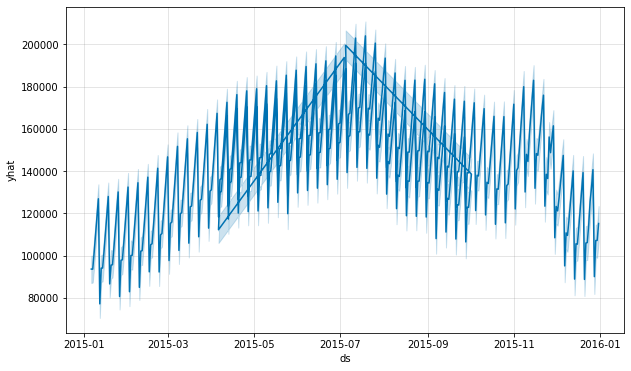

In [47]:
# not super useful to plot like this
plot_forecast_component(m, df_cv, 'yhat')

In [ ]:
df_cv.head()